In [1]:
import zipfile
import pandas as pd
import numpy as np
from PIL import Image
import io
# List of paths to your zip files 
# The four zip files should be:
# 1. inpainting.zip
# 2. insight.zip
# 3. text2img.zip
# 4. wiki.zip (contains real images)

#Make sure you do not commit the data to the repository
#Also make sure to not upload your paths to the repository


zip_paths = [
    '../mle_group_6_data/inpainting.zip',
    '../mle_group_6_data/insight.zip',
    '../mle_group_6_data/text2img.zip',
    '../mle_group_6_data/wiki.zip'
]




# Function to add image data to a DataFrame from multiple zip files
def create_image_dataframe(zip_paths, base_num_images_per_zip=1000):
    # List to store image data
    data = []

    # Process each zip file
    for zip_path in zip_paths:
        print(f"Processing zip file: {zip_path}")  # Print current zip file being processed

        # Determine number of images to process based on zip file name
        if 'wiki.zip' in zip_path:
            num_images_per_zip = base_num_images_per_zip * 3
        else:
            num_images_per_zip = base_num_images_per_zip

        with zipfile.ZipFile(zip_path, 'r') as z:
            image_count = 0  # Initialize image counter for the current zip file

            # Iterate over each item in the zip
            for file in sorted(z.namelist()):
                if file.endswith(('.png', '.jpg', '.jpeg')) and '/' in file:
                    # Read the image
                    image_data = z.read(file)
                    image = Image.open(io.BytesIO(image_data))

                    # Convert image to grayscale and resize
                    image = image.convert('RGB').resize((128, 128), Image.LANCZOS)
                    img_array = np.array(image)

                    # Determine if the image is a deepfake or not based on the zip file
                    is_deep_fake = not zip_path.endswith('wiki.zip')

                    # Append image information to the list
                    data.append({
                        'Zip Folder': zip_path,
                        'Image Path': file,
                        'Is DeepFake': is_deep_fake,
                        'Image Data': img_array.flatten()  # Flatten the array
                    })

                    image_count += 1
                    if image_count >= num_images_per_zip:
                        break  # Stop processing if the image limit is reached
                else:
                    print(file)

    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

# Call the function and store the DataFrame
df_images = create_image_dataframe(zip_paths)

Processing zip file: ../mle_group_6_data/inpainting.zip
inpainting/
inpainting/00/
inpainting/01/
inpainting/02/
inpainting/03/
Processing zip file: ../mle_group_6_data/insight.zip
insight/
insight/00/
insight/01/
insight/02/
insight/03/
Processing zip file: ../mle_group_6_data/text2img.zip
text2img/
text2img/00/
text2img/01/
text2img/02/
text2img/03/
Processing zip file: ../mle_group_6_data/wiki.zip
wiki/
wiki/00/
wiki/01/
wiki/02/
wiki/03/
wiki/04/
wiki/05/
wiki/06/
wiki/07/
wiki/08/
wiki/09/
wiki/10/


In [2]:
image_counts = df_images['Zip Folder'].value_counts()
dataset_size = 0
for count in image_counts:
    dataset_size = dataset_size + count
print (dataset_size)
print("\nNumber of images from each zip folder:")
print(image_counts)

6000

Number of images from each zip folder:
Zip Folder
../mle_group_6_data/wiki.zip          3000
../mle_group_6_data/inpainting.zip    1000
../mle_group_6_data/insight.zip       1000
../mle_group_6_data/text2img.zip      1000
Name: count, dtype: int64


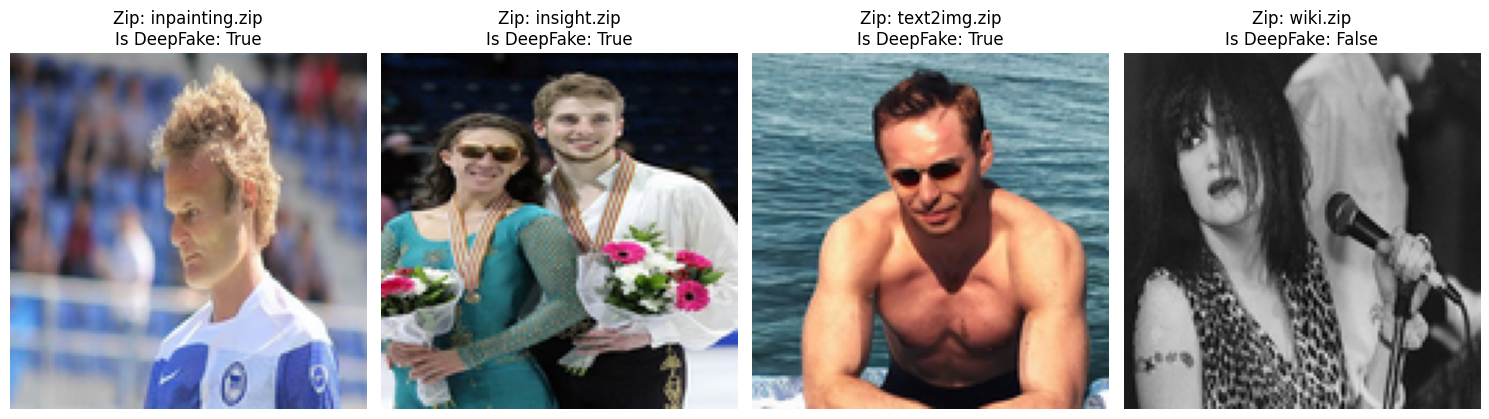

In [3]:
import matplotlib.pyplot as plt
import random

def display_random_images_from_each_zip(df_images):
    # Find unique zip folders
    unique_zip_folders = df_images['Zip Folder'].unique()

    fig, axes = plt.subplots(1, len(unique_zip_folders), figsize=(15, 5))

    # Loop through each unique zip folder
    for i, zip_folder in enumerate(unique_zip_folders):
        # Filter the DataFrame for images only from the current zip folder
        folder_images = df_images[df_images['Zip Folder'] == zip_folder]
        
        # Select a random image from this folder
        random_index = random.randint(0, len(folder_images) - 1)
        image_row = folder_images.iloc[random_index]
        image_data = image_row['Image Data'].reshape(128, 128, 3)  # Reshape the flattened array back to 128x128
        is_deep_fake = image_row['Is DeepFake']  # Retrieve the 'Is DeepFake' status correctly from the row

        # Plot the image
        ax = axes[i] if len(unique_zip_folders) > 1 else axes
        ax.imshow(image_data, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Zip: {zip_folder.split('/')[-1]}\nIs DeepFake: {is_deep_fake}")


    plt.tight_layout()
    plt.show()

# Call the function to display the images
display_random_images_from_each_zip(df_images)


In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

def prepare_data_for_cnn(df_images):
    # Convert flattened images to 2D shape and expand dimensions to include the channel
    images = np.stack(df_images['Image Data'].apply(lambda x: np.reshape(x, (128, 128, 3))))

    # Normalize the images to have values between 0 and 1
    #images = images.astype('float32') / 255.0

    # Extract labels and convert them to integer format
    labels = df_images['Is DeepFake'].values.astype('int')

    return images, labels

# Assuming df_images is your DataFrame containing the required image data
images, labels = prepare_data_for_cnn(df_images)

# Shuffle the data to ensure randomness before stratified splitting
indices = np.arange(len(labels))
np.random.shuffle(indices)
images_shuffled = images[indices]
labels_shuffled = labels[indices]

# Split data into train+val and test using stratified sampling to maintain class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(images_shuffled, labels_shuffled, test_size=0.1, stratify=labels_shuffled, random_state=42)

# Split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, stratify=y_train_val, random_state=42)  # 0.111 is roughly 10% of 0.9

# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32)
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

def count_classes(labels):
    # Count classes in the label array
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

# Print dataset cardinalities and class distribution
print("Training set size:", len(y_train), "Class distribution:", count_classes(y_train))
print("Test set size:", len(y_test), "Class distribution:", count_classes(y_test))
print("Validation set size:", len(y_val), "Class distribution:", count_classes(y_val))

# Take one batch from the dataset and print shapes
for images_batch, labels_batch in train_dataset.take(1):
    print("Images shape:", images_batch.shape)  # Expected shape: (batch_size, 128, 128, 3)
    print("Labels shape:", labels_batch.shape)  # Expected shape: (batch_size,)


Training set size: 4800 Class distribution: {0: 2400, 1: 2400}
Test set size: 600 Class distribution: {0: 300, 1: 300}
Validation set size: 600 Class distribution: {0: 300, 1: 300}
Images shape: (32, 128, 128, 3)
Labels shape: (32,)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import MobileNetV2
#highest accuracy so far is 0.9617 

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False
l2_reg = 0.01

# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg))
])

# Compile the model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [6]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 266ms/step - accuracy: 0.5477 - loss: 2.0762 - val_accuracy: 0.6167 - val_loss: 0.9945
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - accuracy: 0.5832 - loss: 0.9355 - val_accuracy: 0.6217 - val_loss: 0.8181
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 247ms/step - accuracy: 0.5907 - loss: 0.7928 - val_accuracy: 0.5883 - val_loss: 0.7521
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 259ms/step - accuracy: 0.6057 - loss: 0.7369 - val_accuracy: 0.5800 - val_loss: 0.7225
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 250ms/step - accuracy: 0.5989 - loss: 0.7085 - val_accuracy: 0.6200 - val_loss: 0.7036
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.6121 - loss: 0.6928 - val_accuracy: 0.6017 - val_loss: 0.6908
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 249ms/step - accuracy: 0.6079 - loss: 0.6902 - val_accuracy: 0.6067 - val_loss: 0.6882
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.6083 - loss: 0

In [7]:
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

print("Generate predictions for 3 samples")
predictions = model.predict(test_dataset.take(3))
print("predictions shape:", predictions.shape)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.5791 - loss: 0.6758
test loss, test acc: [0.6761071681976318, 0.5849999785423279]
Generate predictions for 3 samples
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step
predictions shape: (96, 1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step


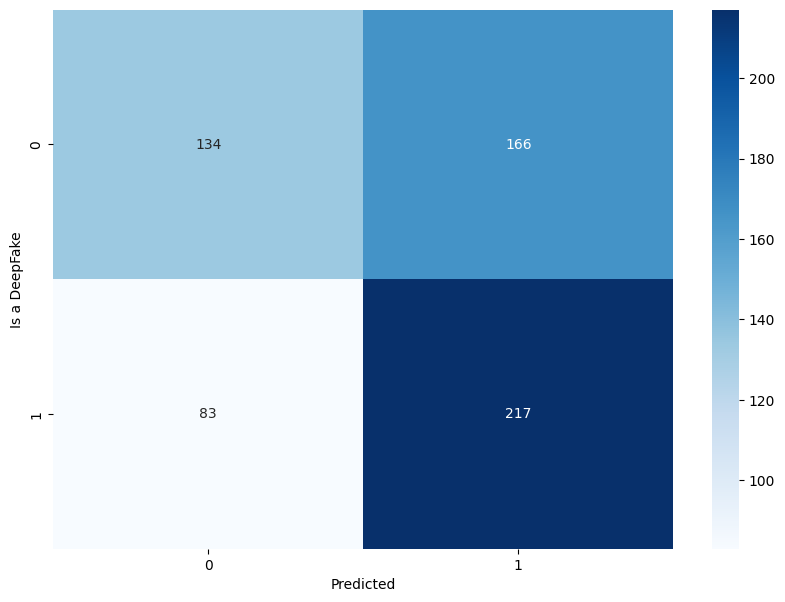

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Get the predicted labels as probabilities
y_pred_prob = model.predict(test_dataset)

# Convert the probabilities into class labels
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Is a DeepFake')
plt.show()

In [25]:
# import lime
# from lime import lime_image
# from tensorflow.keras.preprocessing import image
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt

# # Function to preprocess the image to be model-ready
# def preprocess_image(img_path, target_size):
#     img = image.load_img(img_path, target_size=target_size)
#     img_array = image.img_to_array(img)
#     img_array_expanded_dims = np.expand_dims(img_array, axis=0)
#     return tf.keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)

# # Prepare the image
# img_path = "23300_1962-06-19_2011.jpg"
# processed_image = preprocess_image(img_path, (128, 128))

# # Create a Lime Image Explainer
# explainer = lime_image.LimeImageExplainer()

# # Define a prediction function
# def model_prediction(data):
#     pred = model.predict(data)
#     # For binary classification, Lime needs binary probabilities
#     return np.hstack((1-pred, pred))

# # Explain an image prediction
# explanation = explainer.explain_instance(processed_image[0], 
#                                          model_prediction, # prediction function
#                                          top_labels=1, 
#                                          hide_color=0, 
#                                          num_samples=1000) # number of images that will be sent to classification function

# # Display the image and the mask on the explanation
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
# plt.title('LIME Explanation')
# plt.show()


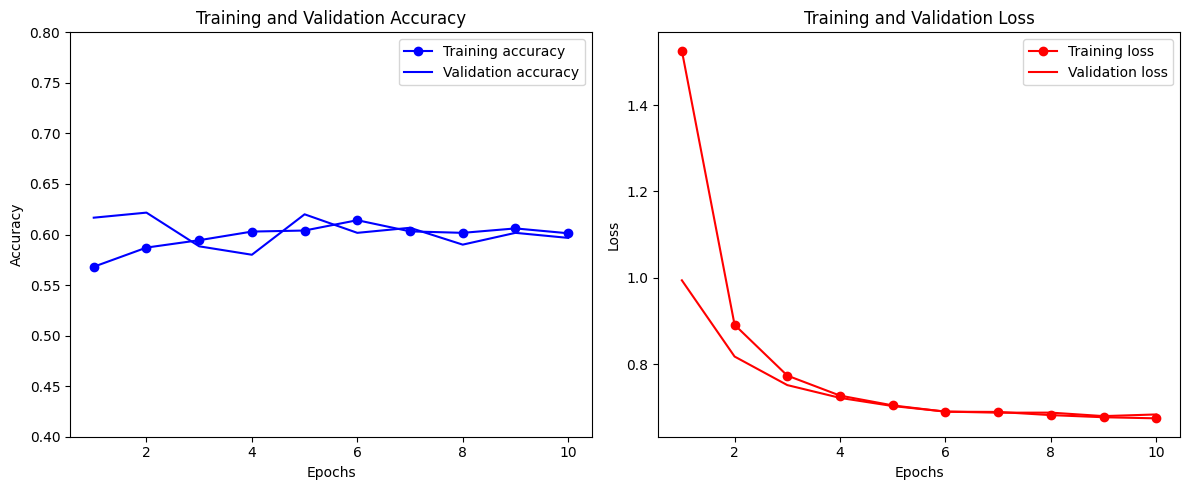

In [26]:
def create_plots(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting the Training and Validation Accuracy graph
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 0.8)
    plt.legend()

    # Plotting the Training and Validation Loss graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

create_plots(history)

In [32]:
from sklearn.metrics import f1_score

def calculate_f1_score(model, test_dataset):
    y_true = []
    y_pred = []
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        
        # Predict the probabilities and apply a threshold to get binary predictions
        probabilities = model.predict(images, verbose=False)
        predictions = (probabilities > 0.5).astype(int)
        y_pred.extend(predictions.flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return f1

f1_score_value = calculate_f1_score(model, test_dataset)
print("F1 Score:", f1_score_value)

F1 Score: 0.6354319180087848


In [30]:
def calculate_accuracy(model, conf_mat, test_dataset):
    # Extracting TP, TN, FP, FN from the already obtained confusion matrix
    TN, FP, FN, TP = conf_mat.ravel() if conf_mat.size == 4 else (conf_mat[0, 0], 0, 0, conf_mat[1, 1] if conf_mat.shape[0] == 2 else 0)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

accuracy_value = calculate_accuracy(model, cm, test_dataset)
print("Accuracy:", accuracy_value)

Accuracy: 0.585
